# **Londra Şehri Bisiklet Kiralama Tahmini**

_Canberk İleri_ - [LinkedIn](https://www.linkedin.com/in/canberk-ileri-1a237947/) <br>
_Salih Can Yılmaz_ - [LinkedIn](https://www.linkedin.com/in/salih-can-yilmaz-678755160/)

Bisiklet kiralama sistemi, şehir trafiğinin azaltılmasını sağlayan yöntemlerden biridir. Trafiğin azalması, hava kirliliğini düşürmek için önemli bir faktördür. Araştırmadaki hipotez, bisiklet kiralamanın saat, gün, mevsim ve hava koşulları ile ilişkisinin yüksek olduğudur. Bu projede, gelecekteki bisiklet kiralama sayıları tahmin edilmeye çalışılacaktır. Gelecekteki kullanım verilerinin iyi tahmin edilmesi, hizmetlerin daha iyi yönetilmesine yardımcı olabilir. Aynı zamanda bu çalışma, makine öğrenimi yöntemlerinin bu tip problemlerde iyi çalışıp çalışmadığının da bir testi olacaktır.

## **Veri Seti**

Bu çalışmada kullanılan veri seti, aşağıdaki üç kaynaktan bir araya getirilmiş:

- https://cycling.data.tfl.gov.uk/ 'Contains OS data © Crown copyright and database rights 2016' and Geomni UK Map data © and database rights [2019] 'Powered by TfL Open Data' - **Bisiklet Kullanımı Verileri**

- https://freemeteo.com - **Hava Durumu Bilgisi**

- https://www.gov.uk/bank-holidays - **Londra'daki Resmi Tatiller**

Bu veri saatlere göre gruplandıktan sonra Kaggle'da paylaşılmıştır. - https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset 

**NOT:** Resmi veride, başlangıç ve bitiş tarihi kolonları bulunmaktadır. Ancak hesaplama işlemlerini kolaylaştırmak amacıyla tüm turlar, her saat için başlangıç zamanına göre gruplanmıştır. Bisiklet kullanım süresinin 1 saati geçtiği durumlarda, bu kullanım sonraki saat için tekrar sayılmayacaktır.

## **Veri Seti Üzerindeki Diğer Çalışmalar**

Bu veri seti üzerinde çalışmaya karar verildiğinde, Kaggle'a henüz bir çalışma yüklenmemişti. Bu süreçte yüklenen çalışmaların önemli bir bölümü, problemi çözmekten ziyade veri üzerindeki analizlerden oluşuyordu. Problemin çözümüyle uğraşan araştırmacılar ise Lineer Regresyon, XGBoost, Random Forest, AdaBoost, BaggingRegressor ve Support Vector Regressor yöntemlerini izlemiş. Bu algoritmalardan farklı olarak çözüm için Yapay Sinir Ağları veya Derin Öğrenme yaklaşımları kullanılmamış. Bu sebeple projede, Yapay Sinir Ağı kullanmayı seçtik. Bunun için TensorFlow ve Keras araçlarından faydalanmayı uygun bulduk.

## **Veri Analizi**

#### **Klavuz Bilgi:**

**"timestamp"** - veri gruplamak için zaman bilgisi<br>
**"cnt"** - kiralanan bisiklet sayısı<br>
**"t1"** - hissedilen sıcaklık (°C)<br>
**"t2"** - gerçek sıcaklık (°C)<br>
**"hum"** - bağıl nem<br>
**"wind_speed"** - rüzgar hızı (km/s)<br>
**"weather_code"** - hava durumu kodu<br>
**"is_holiday"** - tatil mi? (0 / 1)<br>
**"is_weekend"** - haftasonu mu? (0 / 1)<br>
**"season"** - mevsimler (0-ilkbahar ; 1-yaz; 2-güz; 3-kış)<br>

**"weather_code":** <br>
1 = Açık <br>
2 = Parçalı Bulutlu <br>
3 = Yer Yer Açık Bulutlu <br>
4 = Bulutlu <br>
7 = Yağmurlu/ Hafif Sağanak <br>
10 = Fırtınalı Yağmurlu <br>
26 = Karlı <br>
94 = Dondurucu Soğuk/Sisli <br>

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn import preprocessing
import seaborn as sns
from keras.layers import LeakyReLU
from kerastuner.tuners import RandomSearch
import shutil

import seaborn as sns
from PIL import Image 

In [2]:
london = pd.read_csv('london_merged.csv')
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
london.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [4]:
london.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


Timestamp formatındaki zaman sütunu, daha sonra farklı sütunlara bölünmesi için "yıl-ay-gün saat-dakika-saniye" şeklinde formatlandı:

In [5]:
london['timestamp'] = pd.to_datetime(london['timestamp'], format ="%Y-%m-%d %H:%M:%S")

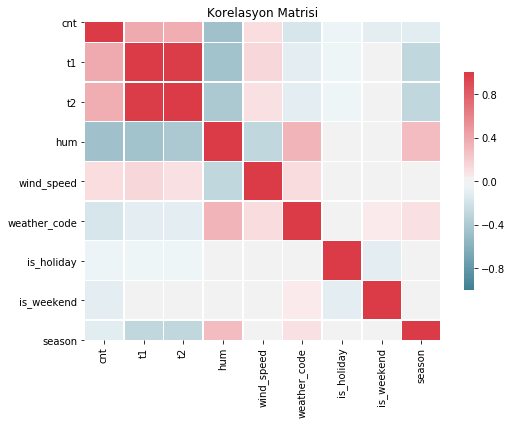

In [6]:
def plot_corr(df):
    f, ax = plt.subplots(figsize=(8, 8))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df.corr(), cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Korelasyon Matrisi')   
plot_corr(london)

$^{[2]}$Aşağıdaki çizimler ve öneriler için linkteki çalışmadan faydalanılmıştır.

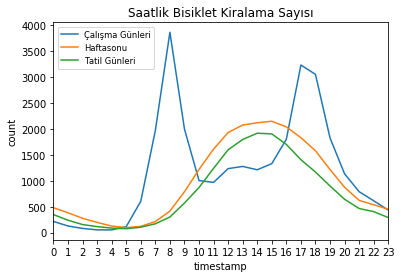

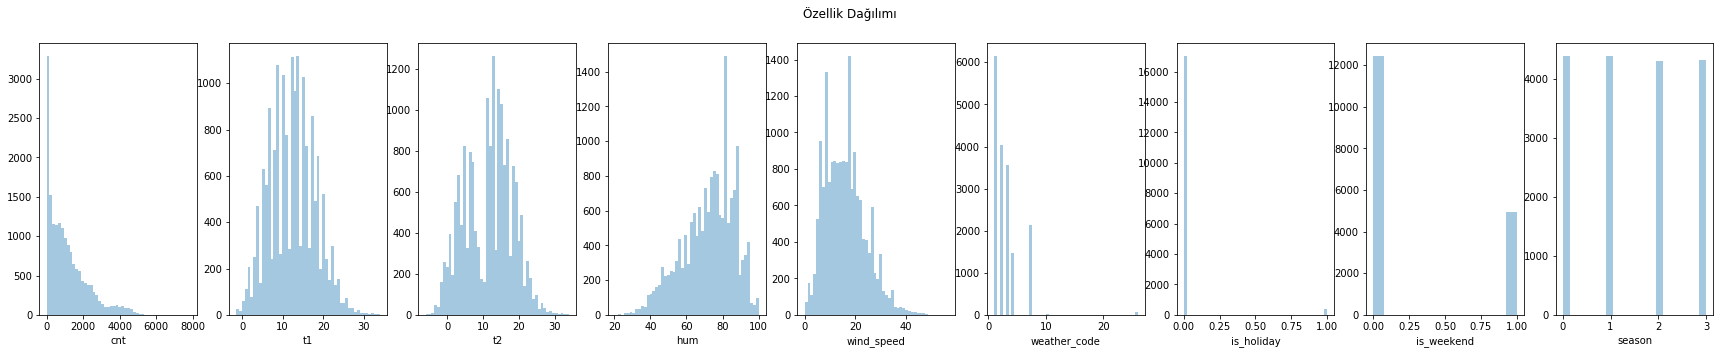

In [7]:
london_non_weekend = london[london['is_weekend'] == 0]
london_non_weekend = london_non_weekend.drop(['is_holiday','is_weekend'],axis=1)
london_is_weekend = london[london['is_weekend'] == 1]
london_is_weekend = london_is_weekend.drop(['is_holiday','is_weekend'],axis=1)
london_is_holiday = london[london['is_holiday'] == 1]
london_is_holiday = london_is_holiday.drop(['is_holiday','is_weekend'],axis=1)
london_non_holiday = london[london['is_holiday'] == 0]
london_non_holiday = london_non_holiday.drop(['is_holiday','is_weekend'],axis=1)

def hourly_plot(df,title):    
    df.groupby(by=df.timestamp.dt.hour)['cnt'].mean().plot()
    plt.title(title)
    plt.xticks(range(24))
    plt.ylabel('count')
    plt.legend(['Çalışma Günleri','Haftasonu','Tatil Günleri'],loc=2, fontsize = 'small')
    
hourly_plot(london_non_weekend, 'Saatlik Bisiklet Kiralama Sayısı')
hourly_plot(london_is_weekend, 'Saatlik Bisiklet Kiralama Sayısı')
hourly_plot(london_is_holiday, 'Saatlik Bisiklet Kiralama Sayısı')

def plot_distribution(london,columns,**kwargs ):    
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.distplot(london[col], ax=axs,**kwargs)
    fig.suptitle('Özellik Dağılımı')    
plot_distribution(london,london.drop(['timestamp'],axis=1).columns, kde=False)

Yukarıdaki görsel, bisiklet kiralama sayısı ile çalışma günleri, haftasonu ve tatil günleri arasındaki ilişkiyi göstermektedir. Bu grafikten yola çıkılarak, haftasonu ve tatil günlerindeki kiralama davranışının aynı seyrettiği gözlemlenir. İkinci grafikte, "is_holiday" sütununun dağılımının dengesiz olduğu görülmektedir. Bu sütunu "is_weekend" sütunuyla gruplayarak hem bu dengesizlik giderilir hem de sergilenen davranışın aynı olması, yapılan işlemi uyumlu hale getirir. "is_holiday" ve "is_weekend" sütunları bir araya getirilerek "is_non_workday" sütunu oluşturuldu. Bu üç grup, çalışma günü olan ve olmayan günler olarak ikiye ayrılmış oldu.

"Saatlik Bisiklet Kiralama Sayısı" grafiği, bize bisiklet kiralamalarının gün içindeki dağılımını göstermektedir. Bu dağılıma göre, bisiklet kiralama sayıları gece çok düşük, gündüz ise geceye göre yüksek seyretmektedir. Bu gözlem, veri setine gece ile gündüzü ayıracak bir sütun eklenmesinin olumlu sonuç verebileceğini göstermektedir. Bu gözlemlerin ışığında, gece ve gündüz bilgisini içerecek olan "is_night" sütununun eklenmesine karar verildi.

Ayrıca bu grafiğe göre, çalışma günlerinde iş giriş ve çıkış saatleri olan 08.00, 17.00 ve 18.00 saatlerinde; tatil günlerinde ise 12.00 ile 18.00 arasında yoğunluk görülmektedir. Yoğun saatleri, diğerlerinden ayırayacak olan "rush_hour" sütunu eklendi.

Timestamp tipindeki zaman verisi yıl, ay, gün ve saat sütunları oluşacak şekilde bölündü.

In [8]:
def merge_and_split_columns(df):
    df['timestamp'] = pd.to_datetime(london['timestamp'], format ="%Y-%m-%d %H:%M:%S")
    
    df['is_non_workday'] = df['is_holiday'] + df['is_weekend']
    df = df.drop(['is_holiday','is_weekend'],axis=1)
         
    df['month'] = df['timestamp'].dt.month 
    df['year'] = df['timestamp'].dt.year 
    df['day']=df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week']=df['timestamp'].dt.dayofweek
         
    df['is_night'] = 0
    df.loc[(df['hour'] < 6) | (df['hour'] > 20), 'is_night'] = 1
    
    df['rush_hour'] = 1
    df.loc[((df['is_non_workday'] == 0) & ((df['hour'] == 8) | (df['hour'] == 17) | (df['hour'] == 18))) | 
            ((df['is_non_workday'] == 1) & ( (df['hour'] == 12) | (df['hour'] == 13) | (df['hour'] == 14) | (df['hour'] == 15) | 
                    (df['hour'] == 16) | (df['hour'] == 17))), 'rush_hour'] = 0
         
    return df

london = merge_and_split_columns(london)

## **Test ve Eğitim Verilerinin Ayrılması**

Veri setindeki veriler iki yıllık periyodik veriler olduğundan, eğitim ve test verileri ayrılırken direkt karıştırarak ayırmak olumsuz sonuçlar doğurabilir. Başka bir yaklaşımla, verilerin herhangi bir kısmından toplu olarak ayırmak da dengesizliğe sebep olabilir. Çünkü bazı aylardan ve mevsimlerden fazla veri seçilmesi, bazılarının ise eksik kalması sistemi yanlış yönlendirecektir.

Bu problemin aşılması için 2015 yılında, herbir mevsimin başlangıç ayının ilk 10 günü, ortancı ayının 10. ile 20. günü arası ve bitiş ayının 20. ile 30. günü arası test verisi için alındı. 2016 yılı için ise ayları ayırma işlemi ilk ayın son 10 günü, ikinci ayın 10. ile 20.günü arasını ve üçüncü ayın ilk 10 günü olmak üzere ayrıldı. Yani verinin 3'te 2'si eğitim, 3'te 1'i ise test için ayrılmış oldu.

In [9]:
def split_train_and_test(london):
    splitMonth = 10

    london = shuffle(london)
    
    
    london_test1 = london[((london.month == 3) | (london.month == 6) | 
            (london.month == 9) |  (london.month == 12)) & (london.day <= splitMonth) & (london.year == 2015)]
    london_test2 = london[((london.month == 1) | (london.month == 4) | 
            (london.month == 7) |  (london.month == 10)) & ((london.day <= splitMonth * 2) & (london.day > splitMonth)) & (london.year == 2015)]
    london_test3 = london[((london.month == 2) | (london.month == 5) | 
            (london.month == 8) |  (london.month == 11)) & (london.day > splitMonth * 2) & (london.year == 2015)]
    london_test4 = london_test1.append(london_test2)
    london_test5 = london_test4.append(london_test3)
      
    london_train1 = london[((london.month == 3) | (london.month == 6) | 
            (london.month == 9) |  (london.month == 12)) & (london.day > splitMonth) & (london.year == 2015)]
    london_train2 = london[((london.month == 1) | (london.month == 4) | 
            (london.month == 7) |  (london.month == 10)) & ((london.day > splitMonth * 2) | (london.day <= splitMonth)) & (london.year == 2015)]
    london_train3 = london[((london.month == 2) | (london.month == 5) | 
            (london.month == 8) |  (london.month == 11)) & (london.day <= splitMonth * 2) & (london.year == 2015)]
    london_train4 = london_train1.append(london_train2)
    london_train5 = london_train4.append(london_train3)
    
    
    london_test6 = london[((london.month == 2) | (london.month == 5) | 
            (london.month == 8) |  (london.month == 11)) & (london.day <= splitMonth) & (london.year == 2016)]
    london_test7 = london[((london.month == 1) | (london.month == 4) | 
            (london.month == 7) |  (london.month == 10)) & ((london.day <= splitMonth * 2) & (london.day > splitMonth)) & (london.year == 2016)]
    london_test8 = london[((london.month == 3) | (london.month == 6) | 
            (london.month == 9) |  (london.month == 12)) & (london.day > splitMonth * 2) & (london.year == 2016)]
    london_test9 = london_test6.append(london_test7)
    london_test10 = london_test9.append(london_test8)
      
    london_train6 = london[((london.month == 2) | (london.month == 5) | 
            (london.month == 8) |  (london.month == 11)) & (london.day > splitMonth) & (london.year == 2016)]
    london_train7 = london[((london.month == 1) | (london.month == 4) | 
            (london.month == 7) |  (london.month == 10)) & ((london.day > splitMonth * 2) | (london.day <= splitMonth)) & (london.year == 2016)]
    london_train8 = london[((london.month == 3) | (london.month == 6) | 
            (london.month == 9) |  (london.month == 12)) & (london.day <= splitMonth * 2) & (london.year == 2016)]
    london_train9 = london_train6.append(london_train7)
    london_train10 = london_train9.append(london_train8)
    
    london_test = london_test5.append(london_test10)
    london_train = london_train5.append(london_train10)
    
    return london_train, london_test
london_train, london_test = split_train_and_test(london)

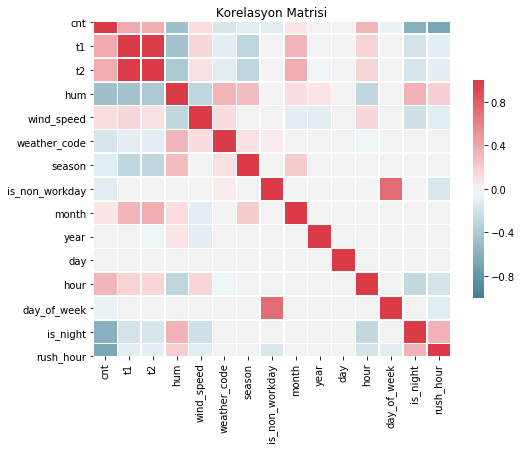

In [10]:
plot_corr(london)

Korelasyon matrisinden yola çıkarak veri üzerinde bazı işlemler yapıldı. Öncelikle t1 ve t2 özellikleri, neredeyse aynı dağılımı gösterdiklerinden hissedilen sıcaklık anlamına gelen t2 korunup t1 düşürüldü. Tatil ve çalışma günlerinin incelenmesi oluşturulan "day_of_week" de kaldırıldı. Elimizde az veri bulundğu için ay, yıl ve mevsim değişkenlerinin dağılımdaki etkisi gözlenemeyecek kadar az olur; bu nedenle veri setinden çıkarıldılar. Zaten matriste olmaması gereken kategorik değişkenlerin ise tip dönüşümü yapıldı. Son olarak verilerin rastgele karıştırılması işlemi yapıldı.

In [11]:
def drop_and_categorize(london_train, london_test):
    london_test = london_test.drop(['timestamp'],axis=1)
    london_test = london_test.drop(['t1'],axis=1)
    london_test = london_test.drop(['day_of_week'],axis=1)
    
    london_train = london_train.drop(['timestamp'],axis=1)
    london_train = london_train.drop(['t1'],axis=1)
    london_train = london_train.drop(['day_of_week'],axis=1)
    
    
    london_test = london_test.drop(['year'],axis=1)
    london_train = london_train.drop(['year'],axis=1)
    
    
    london_train.weather_code = pd.Series(london_train.weather_code, dtype="category")
    london_train.month = pd.Series(london_train.month, dtype="category")
    london_train.day = pd.Series(london_train.day, dtype="category")
    london_train.hour = pd.Series(london_train.hour, dtype="category")
    london_train.is_non_workday = pd.Series(london_train.is_non_workday, dtype="bool")
    london_train.is_night = pd.Series(london_train.is_non_workday, dtype="bool")
    london_train.rush_hour = pd.Series(london_train.is_non_workday, dtype="bool")
    
    
    london_train = london_train.drop(['month'],axis=1)
    london_train = london_train.drop(['season'],axis=1)
    
    
    
    london_test.weather_code = pd.Series(london_test.weather_code, dtype="category")
    london_test.month = pd.Series(london_test.month, dtype="category")
    london_test.day = pd.Series(london_test.day, dtype="category")
    london_test.hour = pd.Series(london_test.hour, dtype="category")
    london_test.is_non_workday = pd.Series(london_test.is_non_workday, dtype="bool")
    london_test.is_night = pd.Series(london_test.is_non_workday, dtype="bool")
    london_test.rush_hour = pd.Series(london_test.is_non_workday, dtype="bool")
    
    
    
    london_test = london_test.drop(['month'],axis=1)
    london_test = london_test.drop(['season'],axis=1)
    
    london_test = shuffle(london_test)
    london_train = shuffle(london_train)
    
    return london_train, london_test

london_train, london_test = drop_and_categorize(london_train,london_test)

Test ve eğitim verilerinde, çıkış sütunu ile eğitimde kullanılacak sütunlar ayrıldı.

In [12]:
def split_target(london_train, london_test):
    london_train = london_train.drop(['day'],axis=1)
    london_train_Y = london_train['cnt']
    london_train_X = london_train.drop(['cnt'],axis=1)
    
    
    
    london_test = london_test.drop(['day'],axis=1)
    london_test_Y = london_test['cnt']
    london_test_X = london_test.drop(['cnt'],axis=1)
    
    return london_train_X, london_train_Y, london_test_X, london_test_Y

london_train_X, london_train_Y, london_test_X, london_test_Y = split_target(london_train,london_test)

Veri setindeki istenmeyen kolonlar düşürülüp, kategorik olması gereken değişkenler de değiştirildikten sonra geri kalan nümerik değişkenler ölçeklendi.

In [13]:
def scaling(london_train_X,london_test_X):
    london_train_X[['t2','hum','wind_speed']] = preprocessing.scale(london_train_X[['t2','hum','wind_speed']])
    london_test_X[['t2','hum','wind_speed']] = preprocessing.scale(london_test_X[['t2','hum','wind_speed']])       
    return london_train_X, london_test_X
london_train_X, london_test_X = scaling(london_train_X,london_test_X)

## **Yapay Sinir Ağı Modeli**

Daha önce tanımladığımız problem, yukarıda hazırlanma aşamalarını anlattığımız veri seti kullanılarak aşağıdaki modelle çözülecektir. Parametreler ve katmanlar, çok sayıdaki deneme sonucunda bulunan en uygun haliyle yazılmıştır.

Aşağıdaki kod blokları, hiperparametre optimizasyonunu sağlamak amacıyla yazılmıştır. "build_model" fonksiyonu, katmanlardaki düğüm sayısının ve öğrenme katsayısının değişim aralığını ifade eder. CustomTuner sınıfı ise RandomSearch sınıfını, "batch_size" ve "epochs" parametrelerini değişebilir kılmak için modifiye eder.

In [14]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(n_cols, input_shape=(n_cols,)),
        keras.layers.Dense(units = hp.Int('unit1', min_value = 32, max_value = 512, step = 32),activation=LeakyReLU(alpha=0.01)),
        keras.layers.Dense(units = hp.Int('unit2', min_value = 32, max_value = 256, step = 32),activation=LeakyReLU(alpha=0.01)),
        keras.layers.Dense(units = hp.Int('unit3', min_value = 0, max_value = 128, step = 16),activation=LeakyReLU(alpha=0.01)),
        keras.layers.Dense(units = hp.Int('unit3', min_value = 0, max_value = 64, step = 16),activation=LeakyReLU(alpha=0.01)),                              
        keras.layers.Dense(1, activation='relu')        
        ])
    keras.optimizers.Nadam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4]))
    #keras.initializers.RandomNormal(mean=0.0, stddev=5, seed=2021)
    model.compile(optimizer='Nadam', loss='mse', metrics=['mae'])
    
    return model

class CustomTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 64, 256, step=64)
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 40, 60 , step=10)#min,max,step
        super(CustomTuner, self).run_trial(trial, *args, **kwargs)

Farklı varyasyonlarla denenen modellerin parametrelerini, bir dosya sistemi şeklinde "directory" ve "project_name" ile belirtilen adrese kaydeder. "execution_per_trial" her bir varyasyonun kaç defa deneneceğini belirtir; bu sadece olasılıksallık aşılmış olur. "Max_trials" ise farklı varyasyon limitini belirtir.

"callbacks", doğrulama kaybı$^{[1]}$ değerine bakar ve beş sefer iyileşme görülmezse eğitimi keser.

In [ ]:
n_cols = london_train_X.shape[1]

shutil.rmtree('./LondonBikeSharing', ignore_errors=True)

tuner = CustomTuner(
    build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    directory='./',
    project_name='LondonBikeSharing')

tuner.search(london_train_X, london_train_Y,
             validation_split=0.15, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5)])

models = tuner.get_best_models(num_models=1)

random_params = tuner.get_best_hyperparameters()[0]

random_model = tuner.hypermodel.build(random_params)

history = random_model.fit(london_train_X.values, london_train_Y.values.flatten(), epochs=75)
test_loss = random_model.evaluate(london_test_X,london_test_Y)

Mean Squarred Error ile hesaplanan "loss" yani öğrenme hatasının değişimi grafik üzerinde gösterilmiştir. Doğrulama hatası olan "val_loss" ise parametreler öğrenildikten sonraki eğitim esnasında doğrulama ayrımı yapılmadığından hesaplanmamıştır.

In [ ]:
def plotLoss(history):  
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.figure(figsize=(20,20))
    plt.show()
    
plotLoss(history)

Kiralama hedefleri ile tahminleri grafik üzerinde gösterilmiştir:

In [ ]:
def plotCount():      
    Predict = random_model.predict(london_test_X)
    Target = london_test_Y.to_numpy()
    Target = Target.reshape(london_test_X.shape[0],1)
    ErrorDiff = Target - Predict
    ErrorDiff = ErrorDiff.reshape(london_test_X.shape[0],1)
    
    plt.plot(Target)
    plt.plot(Predict)
    plt.title('CNT')
    plt.ylabel('Bike Count')
    plt.xlabel('Input')
    plt.legend(['Target','Predict'], loc='upper left')
    plt.figure(figsize=(20,20))
    plt.show()   

plotCount() 

## **Sonuç**

Kurulan yapay sinir ağı modeli, girdi sayısı yani kolon sayısı kadar giriş katmanı içeriyor. Çıkış katmanı ise bir adet çünkü problemimiz bir regresyon problemi. İstenilen çıkış ise bir tam sayı değeridir. Gizli katmanlardaki parametreler ise kurduğumuz optimizasyon aracınca belirlenmiştir.

Alınan en iyi sonucun grafiği aşağıda gösterilmiştir. Siz de kaynak kodları indirip, parametrelerle oynayarak kendi denemelerinizi yapabilirsiniz.

**loss = 65789.3590 <br>
mean_absolute_error = 152.5145**

![title](modelloss_65bin.png)

![title](modelcnt_65bin.png)

## **Referanslar**

[1] https://github.com/deeplearningturkiye/turkce-yapay-zeka-terimleri/blob/master/ingilizce-turkce.md <br>
[2] https://www.kaggle.com/hmavrodiev/bike-sharing-prediction-rf-xgboost